# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t120.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  99.250815  103.762030  108.271065  112.775798  \
0                90         10     6957.0      7672.0      7840.0      7379.0   
1                91         10     7014.0      7655.0      7819.0      7602.0   
2                92         10     6887.0      7536.0      7987.0      7518.0   
3                93         10     6815.0      7769.0      7894.0      7616.0   
4                94         10     6809.0      7686.0      7617.0      7334.0   
..              ...        ...        ...         ...         ...         ...   
175            1135         18     7182.0      7846.0      8240.0      8142.0   
176            1136         18     7186.0      7979.0      8326.0      8003.0   
177            1137         18     7147.0      8069.0      8289.0      7901.0   
178            1138         18     7200.0      7986.0      8261.0      8050.0   
179            1139         18     7093.0      8093.0      8188.0      8038.0   

     117.278356  121.778742  126.274835  130.766640  ...  2473.076347  \
0        7045.0      6394.0      5834.0      5354.0  ...         90.0   
1        6905.0      6467.0      5710.0      5440.0  ...        115.0   
2        6879.0      6271.0      5653.0      5372.0  ...        116.0   
3        7019.0      6368.0      5772.0      5392.0  ...         80.0   
4        7055.0      6427.0      5680.0      5442.0  ...        136.0   
..          ...         ...         ...         ...  ...          ...   
175      7565.0      6802.0      6197.0      5784.0  ...        229.0   
176      7399.0      6808.0      6374.0      5800.0  ...        225.0   
177      7471.0      6796.0      6307.0      5730.0  ...        264.0   
178      7459.0      6856.0      6303.0      5771.0  ...        273.0   
179      7392.0      6880.0      6220.0      5864.0  ...        251.0   

     2476.239604  2479.400013  2482.560815  2485.720391  2488.877123  \
0          106.0        124.0        127.0        127.0        138.0   
1          135.0        129.0        106.0        165.0        143.0   
2           96.0        139.0        130.0        144.0        110.0   
3          115.0        161.0         82.0        153.0        136.0   
4          118.0        132.0        125.0        134.0        193.0   
..           ...          ...          ...          ...          ...   
175        157.0        256.0        217.0        279.0        185.0   
176        242.0        269.0        210.0        235.0        245.0   
177        224.0        238.0        266.0        289.0        243.0   
178        281.0        278.0        186.0        283.0        263.0   
179        283.0        297.0        246.0        301.0        285.0   

     2492.034249  2495.188534  2498.338365  2501.490207  
0           41.0         95.0        113.0        136.0  
1           68.0        154.0         93.0        125.0  
2          120.0        141.0         87.0        147.0  
3           64.0        153.0         95.0         58.0  
4           70.0        159.0         87.0        150.0  
..           ...          ...          ...          ...  
175        204.0        241.0        282.0        214.0  
176        260.0        221.0        238.0        234.0  
177        207.0        186.0        224.0        257.0  
178        169.0        201.0        171.0        167.0  
179        227.0        202.0        246.0        258.0  

[180 rows x 639 columns]

# Test Plots and Baseline Correction

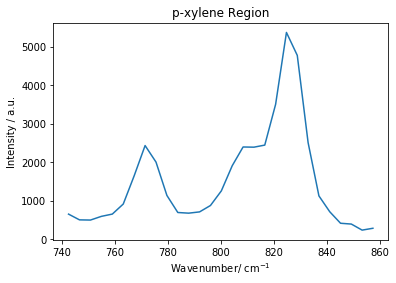

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

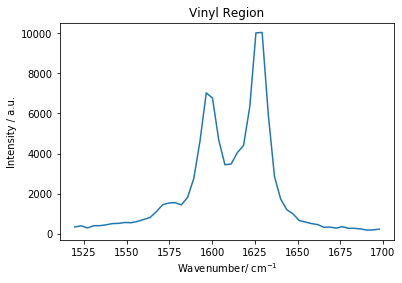

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

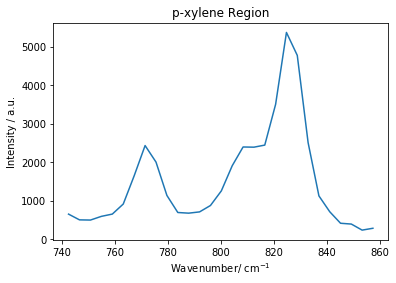

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.618633, 654.0),
 (746.747008, 505.0),
 (750.875475, 500.0),
 (755.002051, 596.0),
 (759.124757, 655.0),
 (845.161878, 417.0),
 (849.231664, 396.0),
 (853.299603, 239.0),
 (857.365695, 287.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

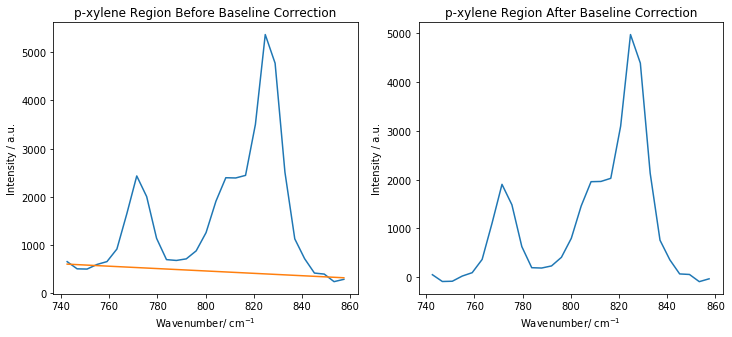

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

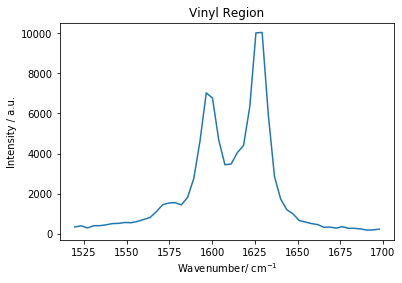

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1519.539364, 335.0),
 (1523.227008, 393.0),
 (1526.911261, 284.0),
 (1530.59394, 397.0),
 (1534.275047, 399.0),
 (1537.952769, 443.0),
 (1541.630734, 503.0),
 (1545.305318, 514.0),
 (1548.976525, 559.0),
 (1552.647977, 546.0),
 (1665.413023, 320.0),
 (1669.018935, 327.0),
 (1672.621543, 278.0),
 (1676.224416, 347.0),
 (1679.822206, 269.0),
 (1683.420263, 266.0),
 (1687.015025, 236.0),
 (1690.608275, 177.0),
 (1694.200013, 188.0),
 (1697.79024, 224.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

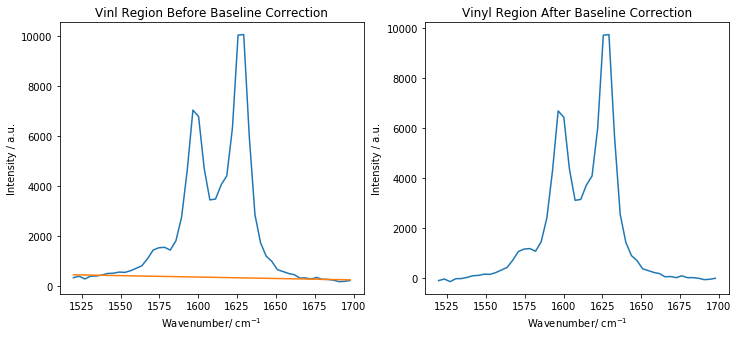

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1519.539364  1523.227008  1526.911261  1530.593940  1534.275047  \
0          335.0        393.0        284.0        397.0        399.0   
1          335.0        356.0        342.0        327.0        349.0   
2          303.0        351.0        286.0        365.0        387.0   
3          294.0        367.0        268.0        374.0        368.0   
4          334.0        335.0        293.0        359.0        403.0   
..           ...          ...          ...          ...          ...   
175        507.0        533.0        505.0        551.0        586.0   
176        559.0        530.0        537.0        525.0        551.0   
177        539.0        518.0        470.0        517.0        607.0   
178        533.0        523.0        464.0        658.0        557.0   
179        558.0        595.0        503.0        601.0        666.0   

     1537.952769  1541.630734  1545.305318  1548.976525  1552.647977  ...  \
0          443.0        503.0        514.0        559.0        546.0  ...   
1          432.0        437.0        457.0        578.0        475.0  ...   
2          413.0        441.0        555.0        514.0        538.0  ...   
3          519.0        412.0        508.0        527.0        501.0  ...   
4          444.0        395.0        499.0        576.0        505.0  ...   
..           ...          ...          ...          ...          ...  ...   
175        663.0        633.0        674.0        764.0        721.0  ...   
176        668.0        692.0        741.0        747.0        821.0  ...   
177        634.0        686.0        764.0        779.0        749.0  ...   
178        647.0        648.0        724.0        811.0        707.0  ...   
179        688.0        757.0        801.0        774.0        715.0  ...   

     1665.413023  1669.018935  1672.621543  1676.224416  1679.822206  \
0          320.0        327.0        278.0        347.0        269.0   
1          434.0        399.0        326.0        318.0        253.0   
2          356.0        342.0        299.0        282.0        300.0   
3          414.0        390.0        312.0        341.0        255.0   
4          331.0        352.0        344.0        275.0        249.0   
..           ...          ...          ...          ...          ...   
175        555.0        480.0        524.0        531.0        496.0   
176        607.0        574.0        609.0        545.0        455.0   
177        568.0        526.0        502.0        534.0        466.0   
178        566.0        596.0        504.0        560.0        496.0   
179        679.0        550.0        548.0        605.0        518.0   

     1683.420263  1687.015025  1690.608275  1694.200013  1697.790240  
0          266.0        236.0        177.0        188.0        224.0  
1          283.0        324.0        244.0        190.0        199.0  
2          188.0        234.0        236.0        188.0        190.0  
3          241.0        217.0        243.0        192.0        138.0  
4          264.0        281.0        183.0        150.0        189.0  
..           ...          ...          ...          ...          ...  
175        453.0        464.0        374.0        394.0        413.0  
176        420.0        433.0        366.0        431.0        446.0  
177        479.0        418.0        444.0        426.0        396.0  
178        475.0        488.0        419.0        372.0        428.0  
179        441.0        434.0        468.0        410.0        430.0  

[180 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 100000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 10

ampL2 = 100000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 6

## Fitting and Plotting (Vinyl Region)

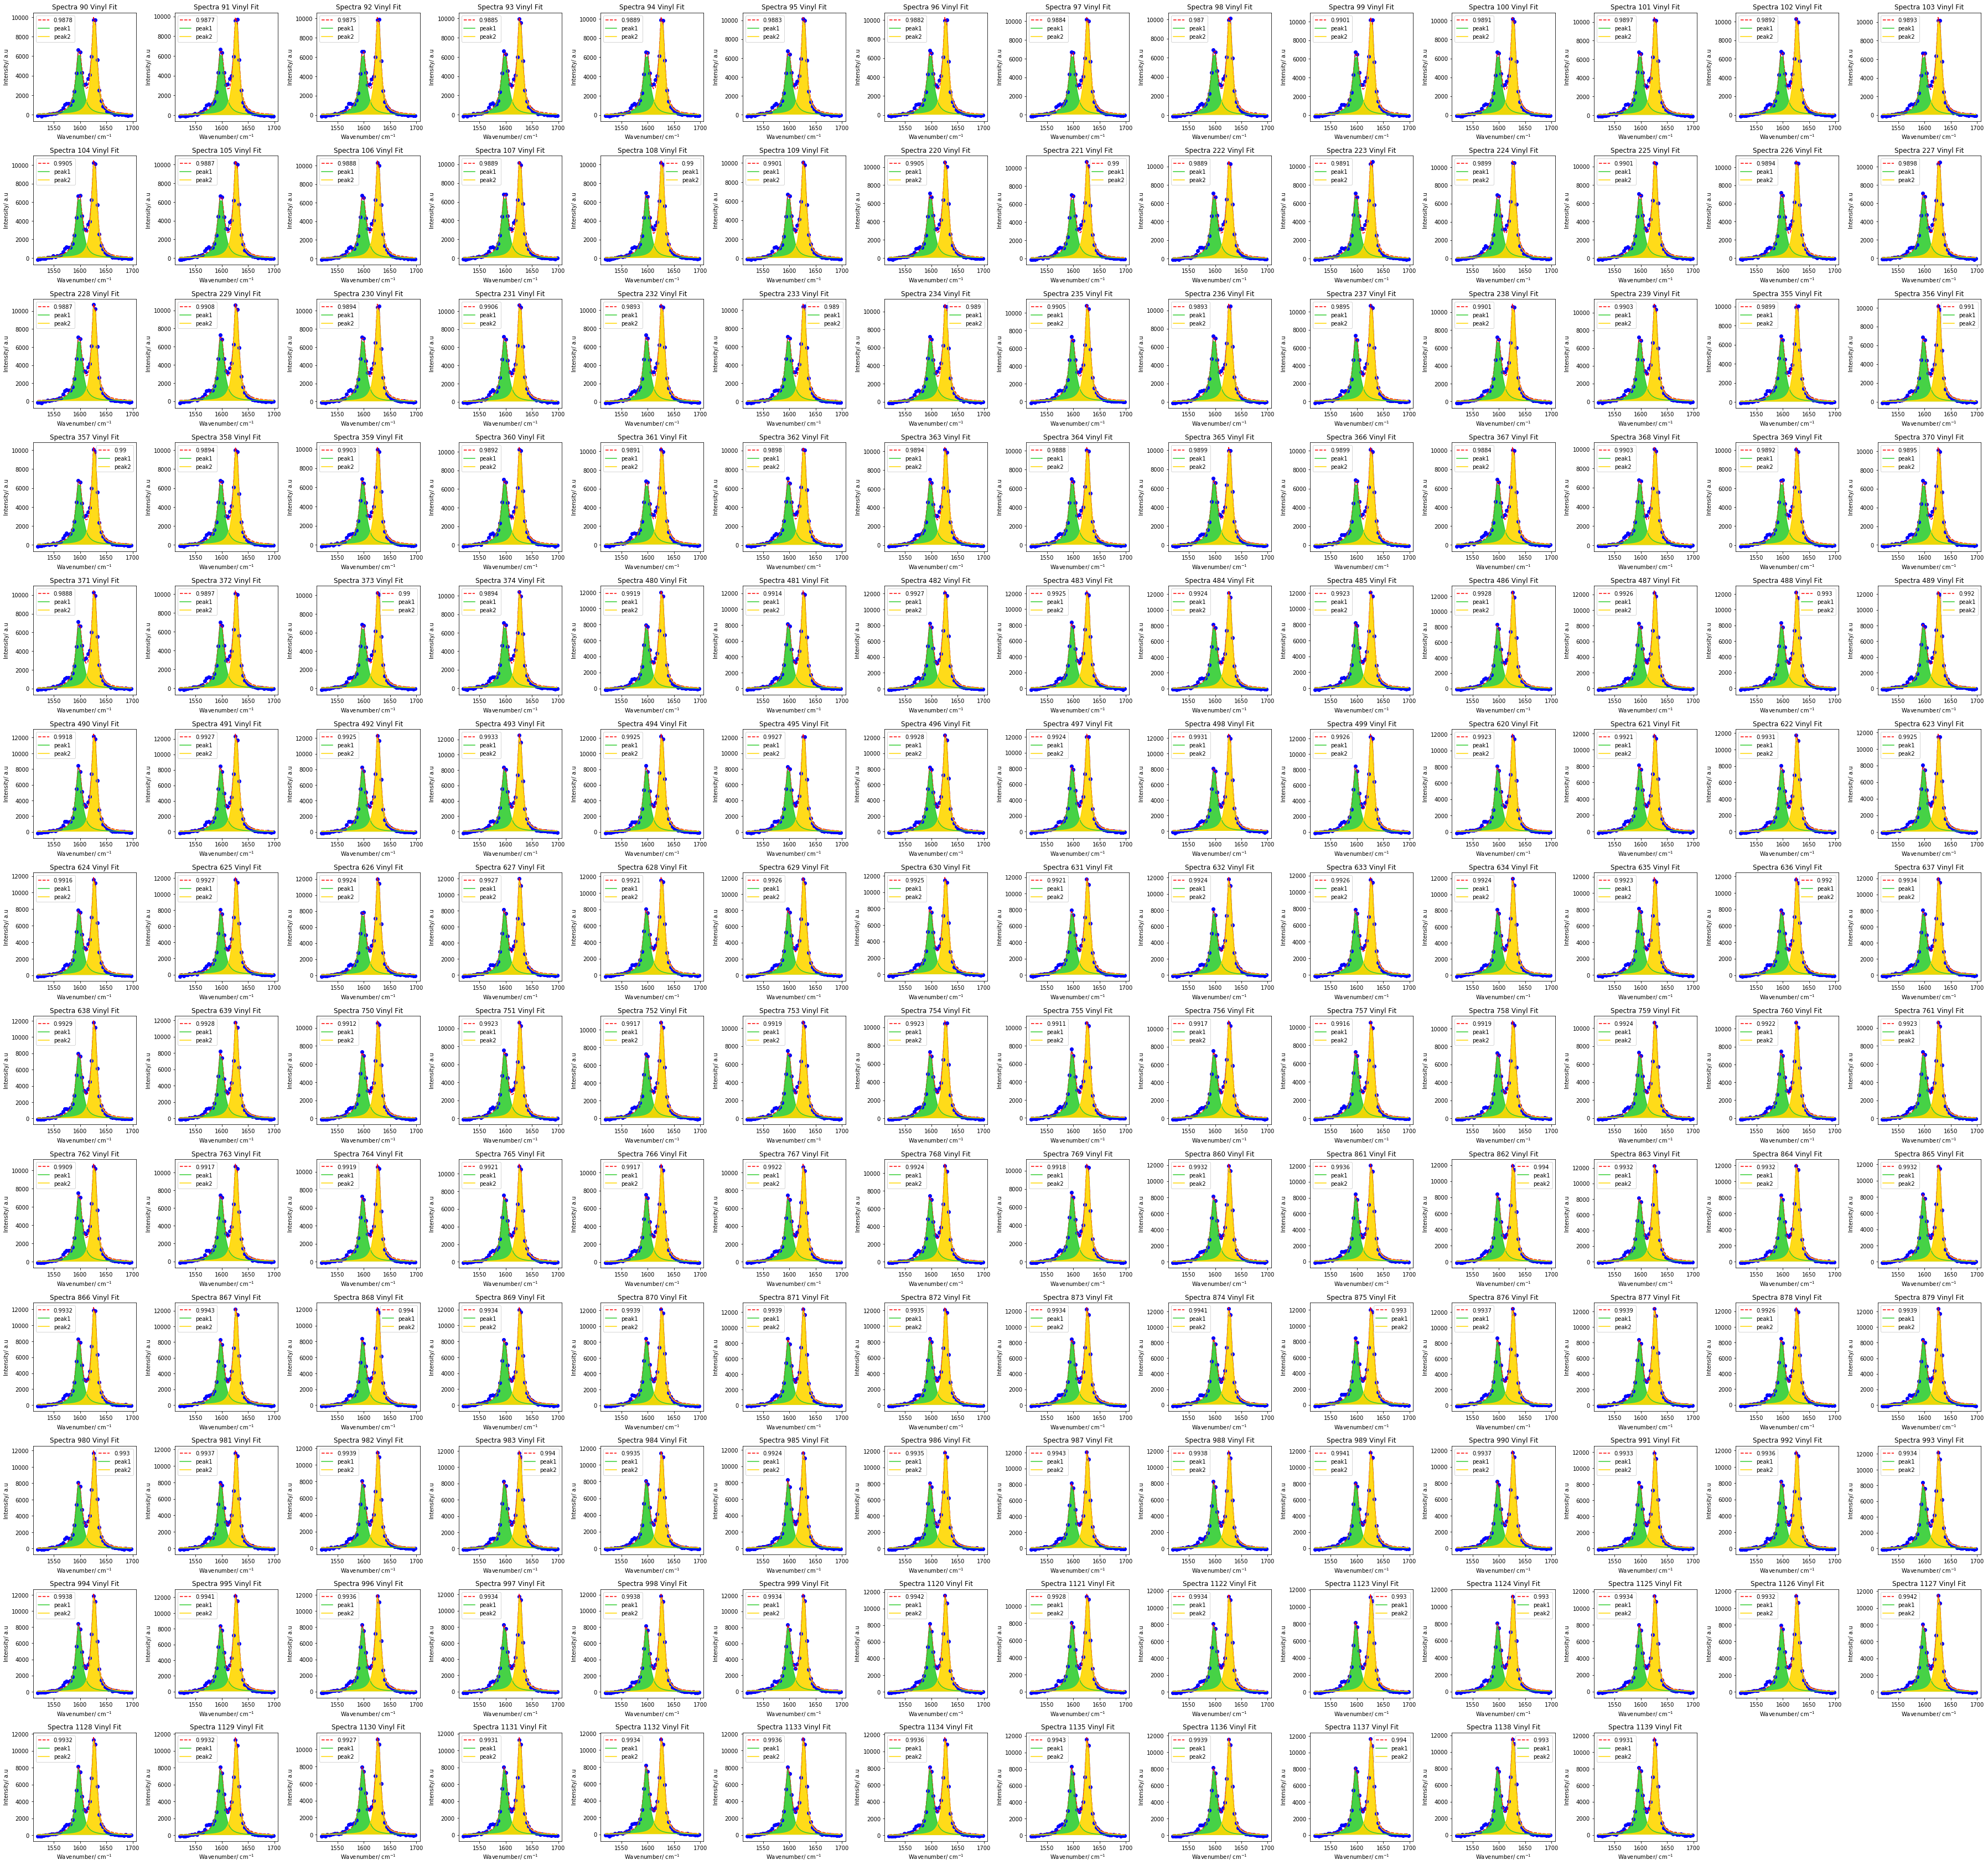

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2       widL1  \
count     180.000000     180.000000   180.000000   180.000000  180.000000   
mean   160912.492244  197975.618995  1598.038629  1627.149141    6.805283   
std      7970.277560   11634.262966     0.203997     0.066931    0.292714   
min    144989.931751  179346.547179  1597.658529  1626.984246    6.232553   
25%    154482.165996  187209.949226  1597.883277  1627.095199    6.540336   
50%    162933.648229  196274.915553  1597.996871  1627.155204    6.757058   
75%    168040.789913  207678.843896  1598.224647  1627.189879    7.078383   
max    176238.660705  221329.187124  1598.500364  1627.316679    7.427091   

            widL2    R2_Vinyl     FWHM_L1     FWHM_L2    Height_L1  \
count  180.000000  180.000000  180.000000  180.000000   180.000000   
mean     5.308884    0.991729   13.610566   10.617768  7551.749027   
std      0.132121    0.001849    0.585428    0.264242   640.145984   
min      5.041859    0.986983   12.465106   10.083717  6375.138004   
25%      5.205488    0.990014   13.080671   10.410976  6902.897462   
50%      5.303526    0.992351   13.514116   10.607052  7870.383171   
75%      5.402752    0.993216   14.156766   10.805503  8106.354462   
max      5.634976    0.994299   14.854182   11.269951  8471.043655   

          Height_L2  
count    180.000000  
mean   11886.144298  
std      878.658331  
min    10287.274983  
25%    11100.944728  
50%    12115.657421  
75%    12671.725555  
max    13221.339927

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0                90         10    174892.676360  0.987839
1                91         10    172970.562780  0.987701
2                92         10    174319.806798  0.987514
3                93         10    174039.300710  0.988523
4                94         10    176910.513360  0.988906
..              ...        ...              ...       ...
175            1135         18    191644.198119  0.994299
176            1136         18    188822.027775  0.993914
177            1137         18    190016.252169  0.993957
178            1138         18    190991.686572  0.992991
179            1139         18    189836.603022  0.993057

[180 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

742.618633  746.747008  750.875475  755.002051  759.124757  763.245576  \
0         654.0       505.0       500.0       596.0       655.0       916.0   
1         651.0       509.0       474.0       507.0       595.0       923.0   
2         652.0       533.0       494.0       570.0       555.0       894.0   
3         629.0       520.0       494.0       542.0       649.0       891.0   
4         691.0       548.0       448.0       584.0       591.0       817.0   
..          ...         ...         ...         ...         ...         ...   
175       806.0       783.0       808.0       860.0       996.0      1220.0   
176       872.0       818.0       773.0       948.0       969.0      1227.0   
177       810.0       819.0       786.0       941.0       974.0      1310.0   
178       905.0       770.0       759.0       876.0       984.0      1263.0   
179       891.0       788.0       865.0       854.0      1022.0      1367.0   

     767.364511  771.479584  775.592776  779.704089  ...  820.686591  \
0        1649.0      2433.0      2004.0      1138.0  ...      3503.0   
1        1629.0      2484.0      2092.0      1178.0  ...      3376.0   
2        1615.0      2427.0      2161.0      1103.0  ...      3428.0   
3        1595.0      2373.0      2075.0      1094.0  ...      3439.0   
4        1613.0      2409.0      2027.0      1202.0  ...      3497.0   
..          ...         ...         ...         ...  ...         ...   
175      2137.0      2899.0      2439.0      1466.0  ...      2076.0   
176      2182.0      2969.0      2495.0      1453.0  ...      2072.0   
177      2155.0      2922.0      2507.0      1492.0  ...      2078.0   
178      2282.0      2874.0      2520.0      1548.0  ...      1978.0   
179      2228.0      2988.0      2504.0      1486.0  ...      2043.0   

     824.769464  828.852443  832.933566  837.012832  841.088281  845.161878  \
0        5368.0      4773.0      2510.0      1127.0       716.0       417.0   
1        5342.0      4793.0      2512.0      1122.0       651.0       448.0   
2        5263.0      4677.0      2632.0      1083.0       670.0       371.0   
3        5349.0      4787.0      2475.0      1104.0       660.0       417.0   
4        5263.0      4813.0      2473.0      1128.0       686.0       503.0   
..          ...         ...         ...         ...         ...         ...   
175      2825.0      2554.0      1625.0       965.0       778.0       581.0   
176      2832.0      2448.0      1538.0       975.0       765.0       599.0   
177      2876.0      2625.0      1494.0       903.0       766.0       669.0   
178      2925.0      2430.0      1509.0       966.0       796.0       643.0   
179      2916.0      2531.0      1515.0      1004.0       803.0       650.0   

     849.231664  853.299603  857.365695  
0         396.0       239.0       287.0  
1         345.0       313.0       251.0  
2         404.0       265.0       295.0  
3         418.0       303.0       346.0  
4         333.0       335.0       297.0  
..          ...         ...         ...  
175       536.0       427.0       518.0  
176       575.0       513.0       516.0  
177       577.0       566.0       474.0  
178       553.0       502.0       471.0  
179       563.0       477.0       507.0  

[180 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 15000
cenL1 = 773 
widL1 = 3

ampL2 = 30000 
cenL2 = 808
widL2 = 5

ampL3 = 110000
cenL3 = 827
widL3 = 7
widL4 = 4

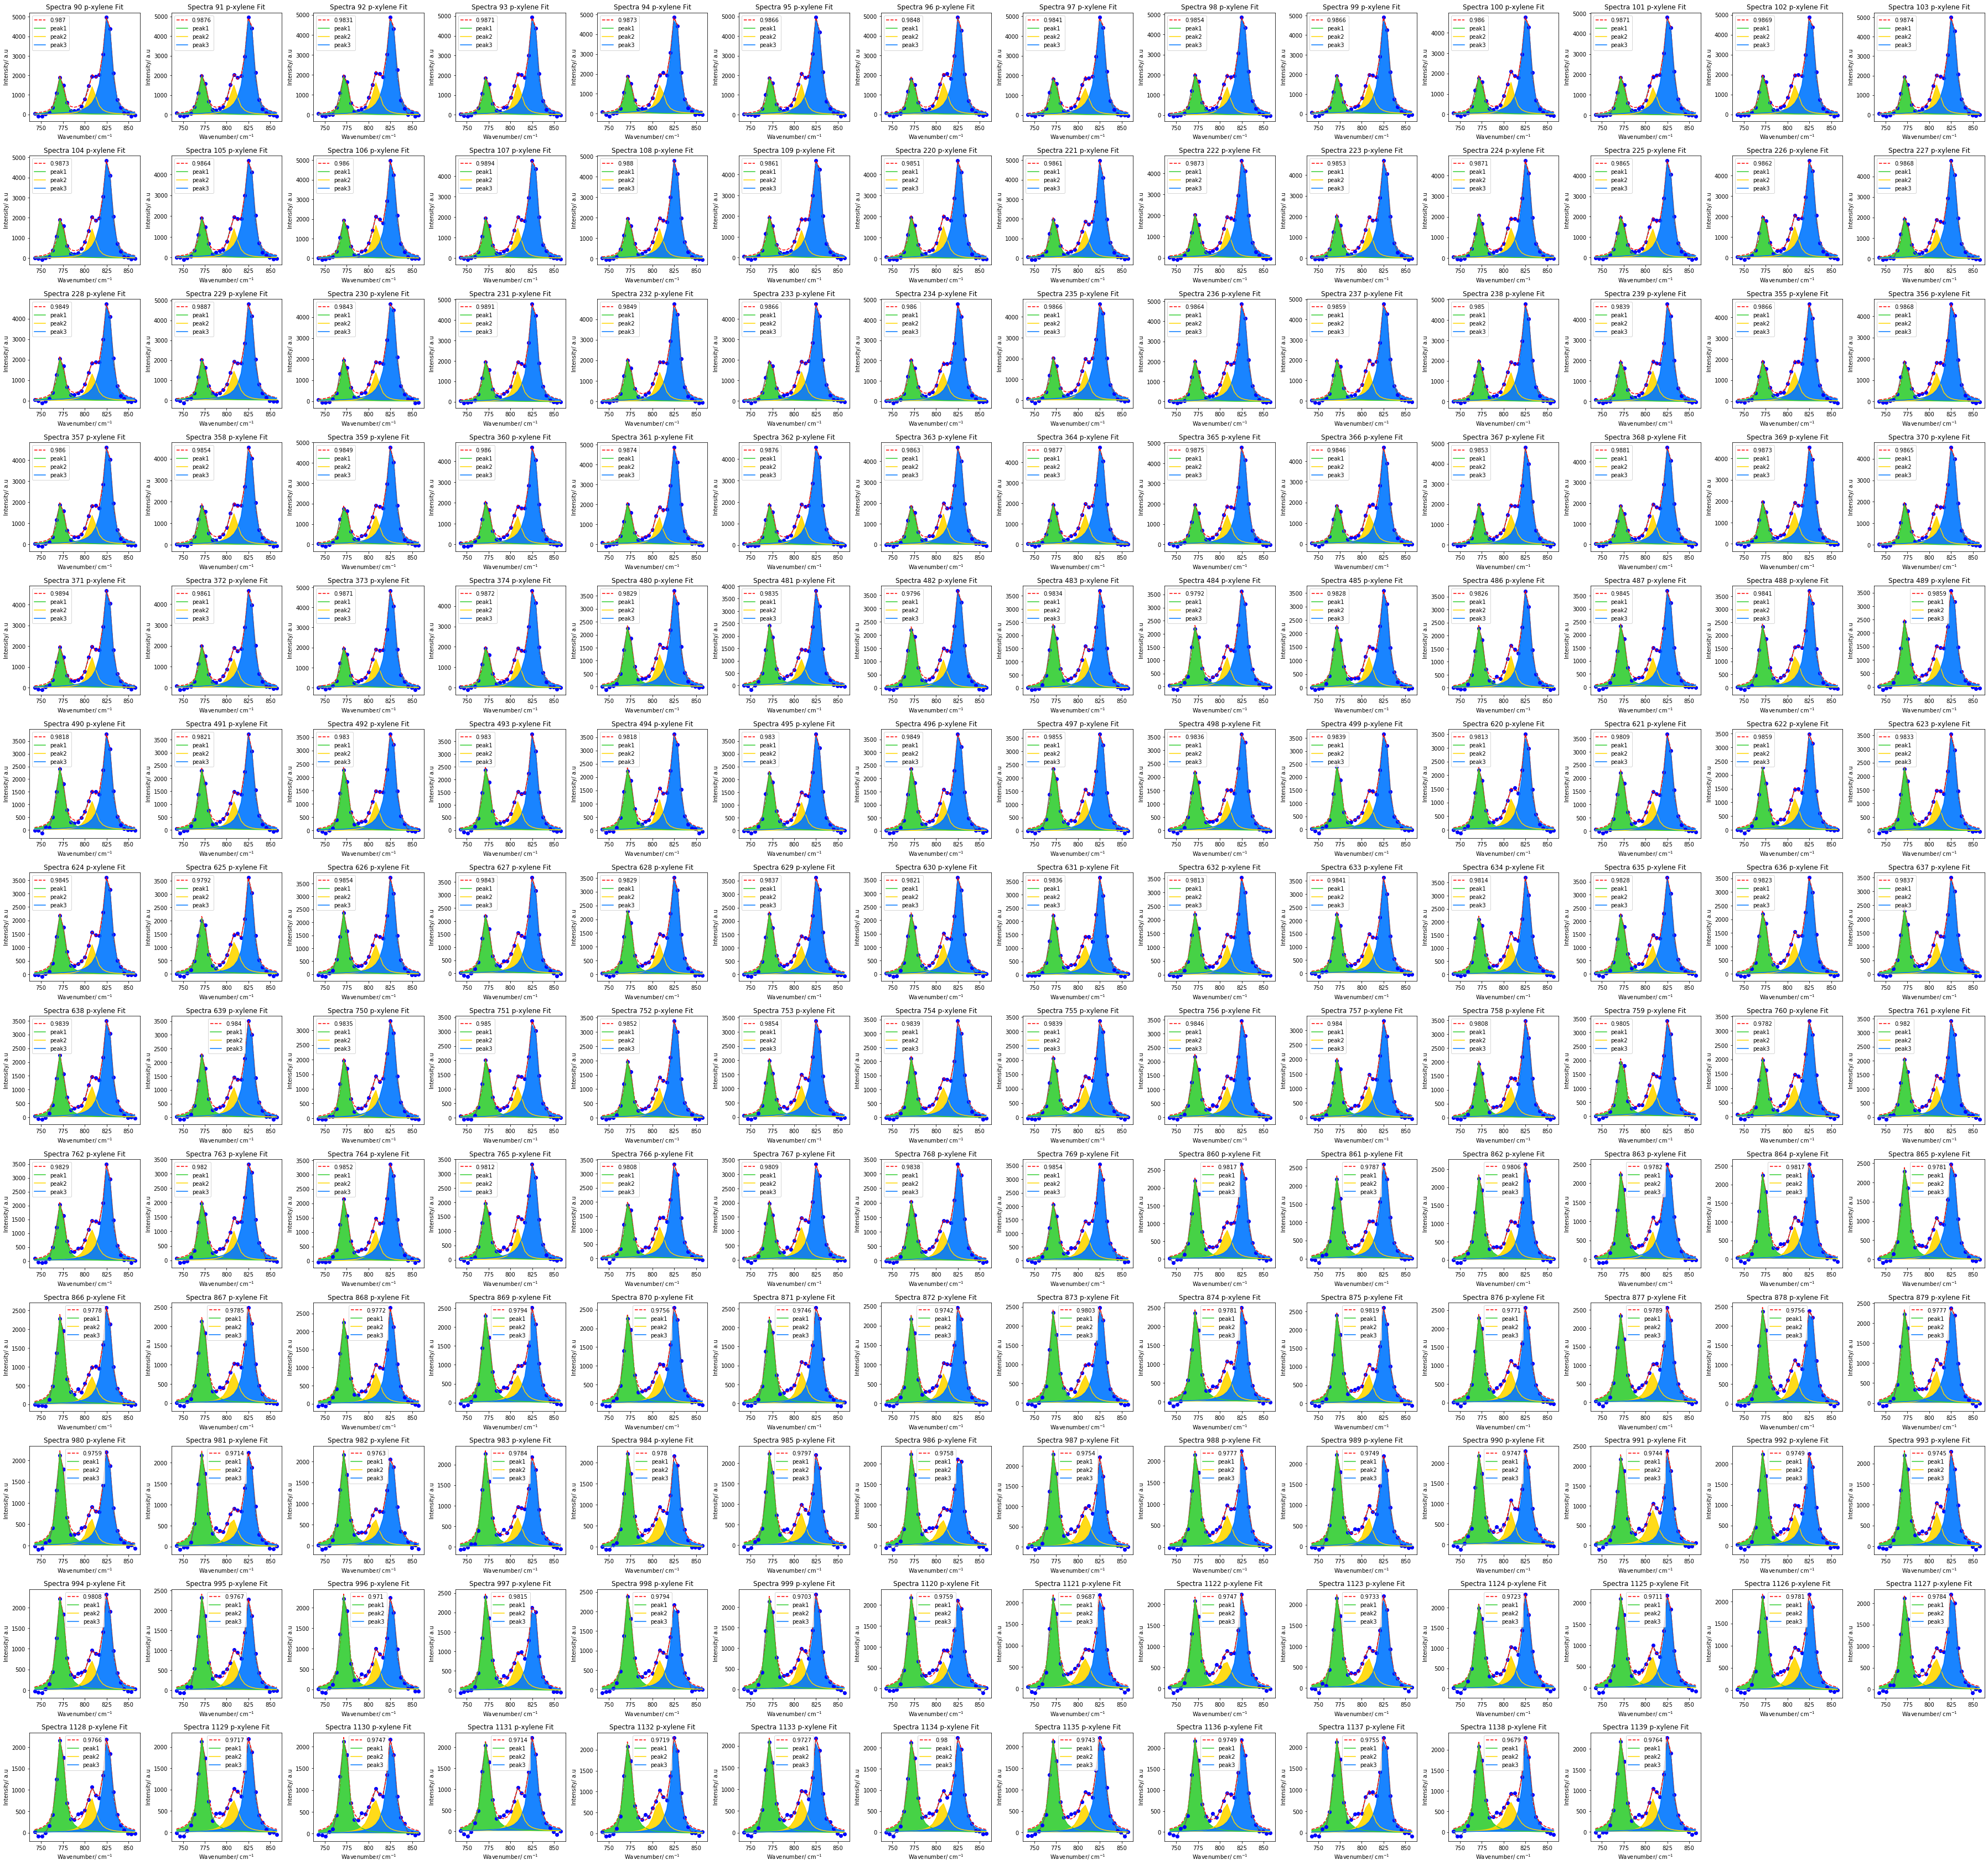

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2         ampL3       cenL1       cenL2  \
count    180.000000    180.000000    180.000000  180.000000  180.000000   
mean   31519.496190  19602.258721  62303.889047  772.482462  808.236117   
std     3525.962198   4078.868130  19013.614051    0.180499    0.398607   
min    24416.802938  11141.969461  33999.398072  771.890637  806.879587   
25%    28039.813913  15934.299864  42723.503961  772.375377  808.037514   
50%    33087.265325  19388.038020  62336.430195  772.477682  808.233663   
75%    34437.505815  23320.878852  83440.169776  772.607296  808.514570   
max    36773.503329  28539.656619  91370.419985  772.978115  809.346266   

            cenL3       widL1       widL2       widL3       widL4     R2_pxyl  \
count  180.000000  180.000000  180.000000  180.000000  180.000000  180.000000   
mean   826.730288    4.491703    5.827147    6.237383    4.312701    0.981865   
std      0.188701    0.265450    0.655661    0.401220    0.157911    0.004865   
min    826.094651    3.663221    4.921672    4.528162    3.791259    0.967864   
25%    826.615728    4.329094    5.363564    6.016929    4.204662    0.978329   
50%    826.742289    4.508387    5.681367    6.295074    4.304747    0.983232   
75%    826.849866    4.656902    6.212771    6.495606    4.401743    0.985885   
max    827.384067    5.185102    8.397531    7.132093    4.774884    0.989435   

          FWHM_L1     FWHM_L2     FWHM_L3    Height_L1    Height_L2  \
count  180.000000  180.000000  180.000000   180.000000   180.000000   
mean     8.983406   11.654294   10.550084  2229.742075  1092.428013   
std      0.530900    1.311323    0.411293   170.777518   287.156188   
min      7.326443    9.843344    8.718202  1906.552728   624.243936   
25%      8.658188   10.727128   10.345043  2090.188657   791.933003   
50%      9.016773   11.362734   10.566657  2221.540800  1095.783436   
75%      9.313804   12.425543   10.789346  2367.389413  1379.908054   
max     10.370203   16.795061   11.827580  2569.247415  1678.362166   

         Height_L3  
count   180.000000  
mean   1871.583459  
std     542.952099  
min    1087.326245  
25%    1298.192295  
50%    1895.638080  
75%    2476.964323  
max    2646.722859

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                90         10    174892.676360  0.987839    84912.378663   
1                91         10    172970.562780  0.987701    83689.117031   
2                92         10    174319.806798  0.987514    82160.198249   
3                93         10    174039.300710  0.988523    81244.699294   
4                94         10    176910.513360  0.988906    82721.407381   
..              ...        ...              ...       ...             ...   
175            1135         18    191644.198119  0.994299    37527.504569   
176            1136         18    188822.027775  0.993914    35667.127228   
177            1137         18    190016.252169  0.993957    36180.361600   
178            1138         18    190991.686572  0.992991    32175.407857   
179            1139         18    189836.603022  0.993057    35346.247329   

      R2_pxyl  
0    0.986988  
1    0.987559  
2    0.983135  
3    0.987093  
4    0.987261  
..        ...  
175  0.974305  
176  0.974913  
177  0.975512  
178  0.967864  
179  0.976435  

[180 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                90         10    174892.676360  0.987839    84912.378663   
1                91         10    172970.562780  0.987701    83689.117031   
2                92         10    174319.806798  0.987514    82160.198249   
3                93         10    174039.300710  0.988523    81244.699294   
4                94         10    176910.513360  0.988906    82721.407381   
..              ...        ...              ...       ...             ...   
175            1135         18    191644.198119  0.994299    37527.504569   
176            1136         18    188822.027775  0.993914    35667.127228   
177            1137         18    190016.252169  0.993957    36180.361600   
178            1138         18    190991.686572  0.992991    32175.407857   
179            1139         18    189836.603022  0.993057    35346.247329   

      R2_pxyl  Vinyl Divide pxyl  
0    0.986988           2.059684  
1    0.987559           2.066823  
2    0.983135           2.121706  
3    0.987093           2.142162  
4    0.987261           2.138630  
..        ...                ...  
175  0.974305           5.106766  
176  0.974913           5.294007  
177  0.975512           5.251917  
178  0.967864           5.935952  
179  0.976435           5.370771  

[180 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
10                     20.0  2.157280  0.059813  2.059684  2.118228  2.148430   
11                     20.0  2.310308  0.042484  2.246333  2.281683  2.304352   
12                     20.0  2.260401  0.048678  2.170720  2.223879  2.264082   
13                     20.0  3.437051  0.066523  3.311507  3.390982  3.436897   
14                     20.0  3.444537  0.102710  3.255073  3.390891  3.434331   
15                     20.0  3.199915  0.084124  3.041634  3.145236  3.221179   
16                     20.0  4.994108  0.164897  4.485697  4.952294  5.025772   
17                     20.0  5.631145  0.283945  5.304265  5.362160  5.586806   
18                     20.0  5.443330  0.217869  5.106766  5.293907  5.381743   

                               
                75%       max  
Condition                      
10         2.192972  2.282772  
11         2.335245  2.409136  
12         2.297579  2.360120  
13         3.486424  3.552092  
14         3.495153  3.734477  
15         3.259006  3.328903  
16         5.051725  5.221065  
17         5.809648  6.235494  
18         5.576620  5.935952

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(10,19)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0         10    2.157280            0.059813
1         11    2.310308            0.042484
2         12    2.260401            0.048678
3         13    3.437051            0.066523
4         14    3.444537            0.102710
5         15    3.199915            0.084124
6         16    4.994108            0.164897
7         17    5.631145            0.283945
8         18    5.443330            0.217869

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201020 High Throughput Experiment Conditions 10 to 18\Online Raman\df_t120_ratio.csv')